In [88]:
import sqlite3
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import ensemble
import matplotlib.pyplot as plt
import numbers
import datetime as dt

In [2]:
conn = sqlite3.connect("SFdatabase.sqlite")
trip_df_orig = pd.read_sql_query("SELECT * FROM trip", conn)
station_df_orig = pd.read_sql_query("SELECT * FROM station", conn)
weather_df_orig = pd.read_sql_query("SELECT * FROM weather",conn)
curr = conn.cursor()

In [3]:
weather_df = weather_df_orig[["date","mean_temperature_f","mean_humidity","precipitation_inches","zip_code"]]
weather_df = weather_df[weather_df['zip_code']==94107]

In [4]:
weather_df.is_copy = False
weather_df['date']=pd.to_datetime(weather_df["date"]).map(lambda x: x.date())

In [5]:
trip_df_orig['start_date']=pd.to_datetime(trip_df_orig["start_date"],infer_datetime_format=True)
trip_df_orig['end_date']=pd.to_datetime(trip_df_orig["end_date"],infer_datetime_format=True)

In [6]:
trip_df_orig['date']=trip_df_orig["start_date"].map(lambda x: x.date())
trip_df_orig['e_date']=trip_df_orig["end_date"].map(lambda x: x.date())

In [7]:
trip_df_orig.columns

Index(['id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'subscription_type', 'zip_code', 'date', 'e_date'],
      dtype='object')

In [91]:
df_final = trip_df_orig.merge(weather_df, how='left', on='date')

# Logistic Regression portion

In [92]:
temp = pd.get_dummies(df_final["subscription_type"])
#temp_station = pd.get_dummies(df_final["start_station_id"])
#temp_station2 = pd.get_dummies(df_final["end_station_id"])
y = df_final["end_station_id"]
df_final['start_date']=df_final['start_date'].map(dt.datetime.toordinal)
df_final.drop(["bike_id","end_date","id","duration","subscription_type","start_station_name","end_station_name","e_date","date","zip_code_x","zip_code_y","end_station_id"],inplace=True,axis=1)
#df_final = pd.concat([df_final,temp,temp_station],axis=1)
df_final = pd.concat([df_final,temp],axis=1)
df_final.head()

,start_date,start_station_id,mean_temperature_f,mean_humidity,precipitation_inches,Customer,Subscriber
0,735109,64,68,75,0,0,1
1,735109,66,68,75,0,0,1
2,735109,66,68,75,0,0,1
3,735109,66,68,75,0,0,1
4,735109,66,68,75,0,0,1


In [93]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_final, y, test_size=0.2, shuffle=True)

In [109]:
#log_reg = linear_model.LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=290)
rand_forest = ensemble.RandomForestClassifier(verbose=3,n_jobs=-1,n_estimators=10,class_weight="balanced")

In [110]:
X_train.is_copy = False
X_test.is_copy = False
X_train.replace('T',0,inplace=True)
X_test.replace('T',0,inplace=True)

In [111]:
rand_forest.fit(X_train, y_train)
#log_reg.fit(X_train, y_train)

building tree 1 of 10building tree 2 of 10building tree 3 of 10


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.6s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=3, warm_start=False)

In [112]:
y_pred = rand_forest.predict(X_test)

[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished


In [113]:
pd.value_counts(y_pred)

82    5495
51    5263
58    5010
59    4494
72    4366
64    4267
61    4135
74    3918
42    3890
46    3838
62    3754
65    3708
48    3566
41    3435
45    3381
77    3378
47    3378
68    3332
75    3285
57    3243
60    3222
49    3147
69    3125
73    3114
56    3071
71    3062
66    3048
54    3047
63    2859
67    2714
      ... 
6      451
29     445
7      429
11     425
32     421
14     419
8      404
30     404
34     397
84     396
35     392
12     382
3      373
13     364
9      359
16     356
10     332
31     315
80     309
36     257
22     255
37     247
33     238
38     171
25     112
26      98
23      65
21      61
24      57
83      49
Length: 70, dtype: int64

In [114]:
(y_test==y_pred).mean()

0.12091020359424444

In [47]:
Counter(log_reg.predict(X_test))

Counter({70: 133992})

In [115]:
rand_forest.feature_importances_

array([ 0.18175407,  0.59891445,  0.08955558,  0.11398475,  0.01104157,
        0.00281174,  0.00193784])

# Linear Regression Section

In [122]:
df_final2 = trip_df_orig.merge(weather_df, how='left', on='date')
temp = pd.get_dummies(df_final2["subscription_type"])
#temp_station = pd.get_dummies(df_final2["start_station_id"],prefix='start')
#temp_station2 = pd.get_dummies(df_final2["end_station_id"],prefix='end')
y = df_final2["duration"]
df_final2['start_date']=df_final2['start_date'].map(dt.datetime.toordinal)
#df_final2['end_date']=df_final2['end_date'].map(dt.datetime.toordinal)
df_final2.drop(["bike_id","end_date","id","subscription_type","start_station_name","end_station_name","e_date","date","zip_code_x","zip_code_y","start_station_id","end_station_id"],inplace=True,axis=1)
#df_final2 = pd.concat([df_final2,temp,temp_station,temp_station2],axis=1)
df_final2 = pd.concat([df_final2, temp],axis=1)
df_final2.head()

,duration,start_date,mean_temperature_f,mean_humidity,precipitation_inches,Customer,Subscriber
0,174,735109,68,75,0,0,1
1,1067,735109,68,75,0,0,1
2,1131,735109,68,75,0,0,1
3,1117,735109,68,75,0,0,1
4,1118,735109,68,75,0,0,1


In [123]:
#model = linear_model.LinearRegression()
model = ensemble.RandomForestRegressor(verbose=3,n_jobs=-1)

In [124]:
y = df_final2['duration']
df_final2.drop('duration',inplace=True,axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_final2, y, test_size=0.2, shuffle=True)

In [125]:
X_train.is_copy = False
X_test.is_copy = False
X_train.replace('T',0,inplace=True)
X_test.replace('T',0,inplace=True)

In [126]:
model.fit(X_train, y_train)

building tree 1 of 10building tree 2 of 10building tree 3 of 10


building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.8s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=3, warm_start=False)

In [127]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


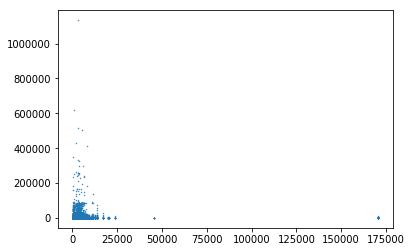

In [128]:
plt.scatter(model.predict(X_test),y_test,s=0.2)
plt.show()

In [130]:
metrics.mean_absolute_error(y_test,y_pred)

955.87209449745978

In [129]:
metrics.r2_score(y_test,model.predict(X_test))

[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


-0.11427942989752182